#  Minimum Spanning Tree Problem 
## Complete Subtour Elimination Constraints (SEC) formulation  

This formulation contains all SEC inequalities.
See slides **trees.pdf** for details


In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display


In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos, width=0.1, fontsize=9)
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    

def DrawSol (x):
    for i,j in G.edges():
        lab = x[i,j].x
        G[i][j]['capacity'] = x[i,j].x
        if x[i,j].x > 0.00001:
            if x[i,j].x > 0.999999:
                DrawG.add_edge(i, j, color='black', label=lab, fontsize=9)
            else:
                DrawG.add_edge(i, j, color='red', label=lab)
    path=str(basename)+'_sol.svg'
    DrawG.draw (path=path, format='svg')
    DrawG.delete_edges_from(DrawG.edges())
    
class args:
    filename = None
    scale = 40

In [3]:
args.filename = "mst.gml"
args.scale = 20

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


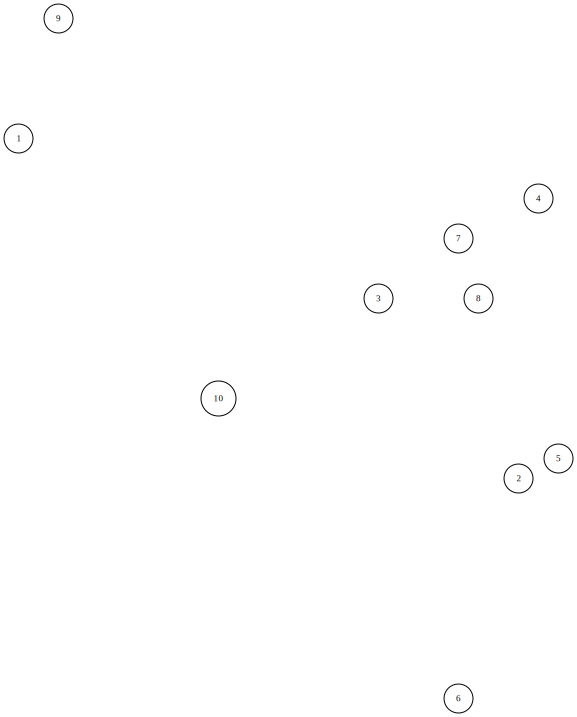

In [4]:
DrawInitialGraph()
display(SVG(filename=basename+'.svg'))



### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

## Subtour Elimination Constraints formulation (SEC): separation problem

### Problem formulation

$$
\max \sum_{e=\{i,j\} \in E} x^*_e w_{ij} - \sum_{j \in V} z_j \\
w_{ij} - z_i \le 0,\; w_{ij} - z_j \le 0 \;\;\; \forall \{i,j\} \in E\\
z_k = 1\\
0 \le z \le 1, 0 \le w \le 1
$$

In [6]:
#
# Subtour Elimination Constraints: separation
# 

def SECseparation (x, G, node):
    
    #
    # Definition of the separation problem
    #
    
    SECsep = gb.Model()
    
    #
    # Variables w_ij and z_i
    #
    
    w = SECsep.addVars(G.edges(), \
                       obj=[x[u,v].x for u,v in G.edges()], \
                       ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS, name='w')
        
    z= SECsep.addVars(G.nodes(), \
                      obj = -1.0, \
                      ub = 1.0, \
                  vtype=gb.GRB.CONTINUOUS, name='z')

    #
    # Objective function
    #

    SECsep.ModelSense = -1
    
    #
    # Constraints
    #

    SECsep.addConstrs((w[i,j] - z[i] <= 0 \
                       for i,j in G.edges()), name = 'WZ1')
    
    SECsep.addConstrs((w[i,j] - z[j] <= 0 \
                       for i,j in G.edges()), name = 'WZ2')
    
    SECsep.addConstr(z[node] == 1, name="Fixing")
    
    SECsep.update()
    
    SECsep.write('sep.lp')

    SECsep.optimize()

    if (SECsep.objVal) > -1.0:
        SEC = [i for i in G.nodes() if z[i].x > 0.1]
        return True, SEC
    else:
        return False, None


## Master problem 

The master problem now contains only the cardinality constraint


In [7]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()], ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS, name='x')

# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

In [8]:
mst.optimize()

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]
Presolve removed 0 rows and 3 columns
Presolve time: 0.01s
Presolved: 1 rows, 42 columns, 42 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0070000e+03   8.000000e+00   0.000000e+00      0s
       1    5.0160000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  5.016000000e+03


## Cutting plane algorithm

Now the cutting plane algorithm. At each iteration, after the resolution of the master LP (note, the relaxation) a sequence of separation problems are solved
and if there exists a violated SEC then it is added to the master. The cutting plane is interactive, thus press ``Enter`` key to continue.

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.016000000e+03
Current solution value: 5016.0


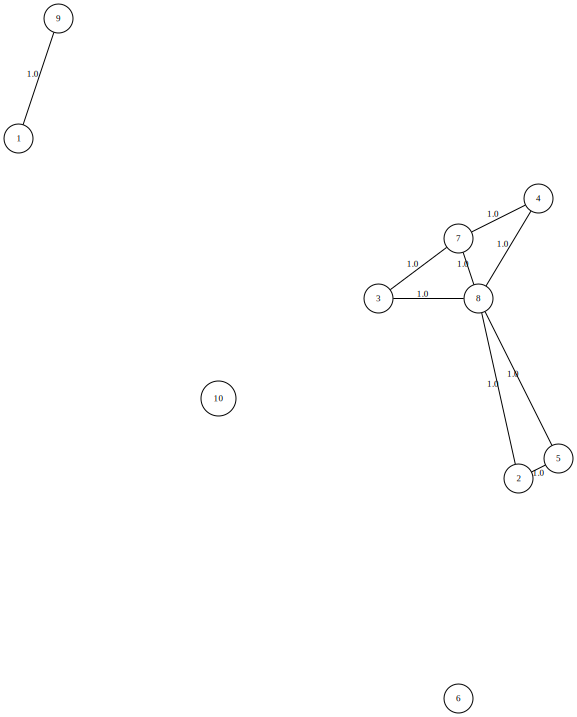

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 75 rows and 41 columns
Presolve time: 0.02s
Presolved: 16 rows, 14 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   4.000000e+00   0.000000e+00      0s
       6    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.03 seconds
Optimal objective  1.000000000e+00
Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8]
Press Enter to continue...

Optimize a model with 2 rows, 45 columns and 66 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0160000e+03   2.000000e+00   0.000

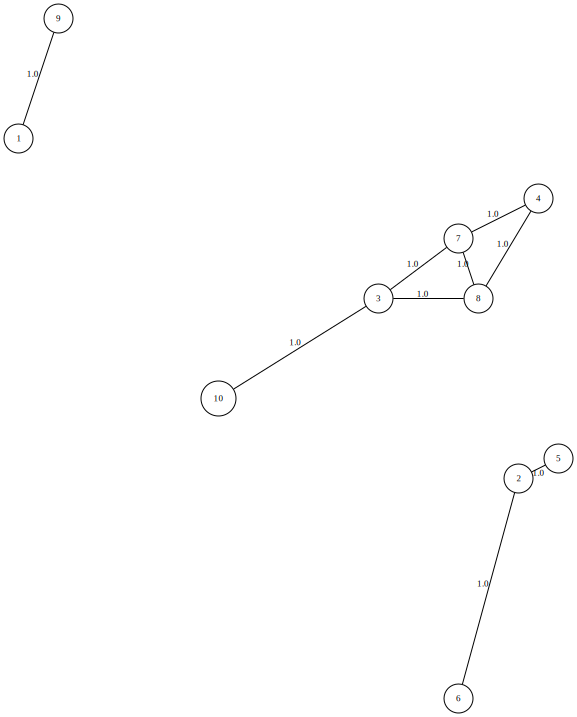

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 81 rows and 46 columns
Presolve time: 0.07s
Presolved: 10 rows, 9 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       4   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.10 seconds
Optimal objective -0.000000000e+00
Found violated subtour. S = [1, 3, 4, 7, 8]
Press Enter to continue...

Optimize a model with 3 rows, 45 columns and 76 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2840000e+03   1.000000e+00   0.000000e+00

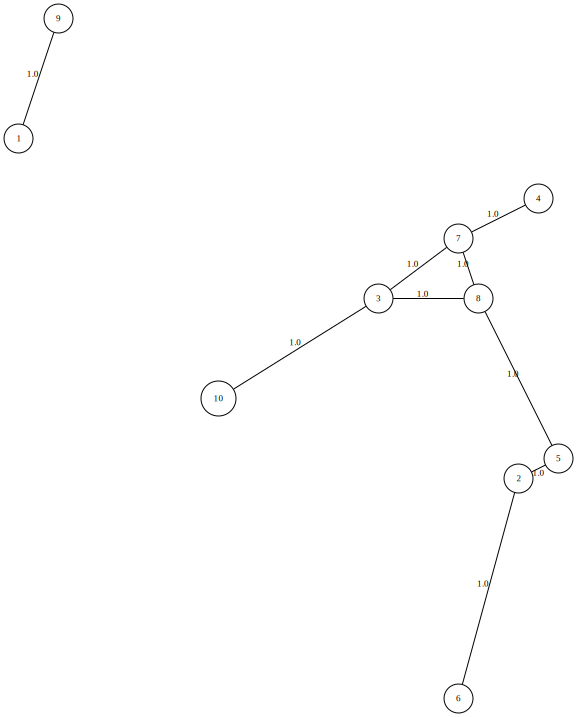

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

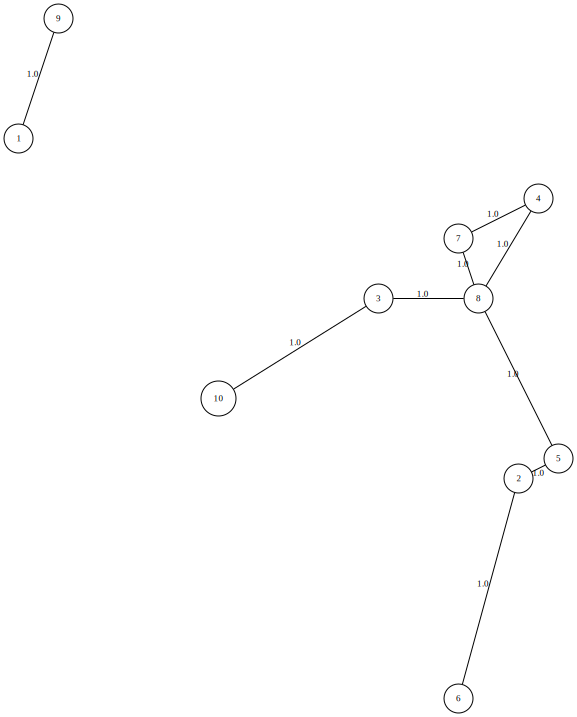

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

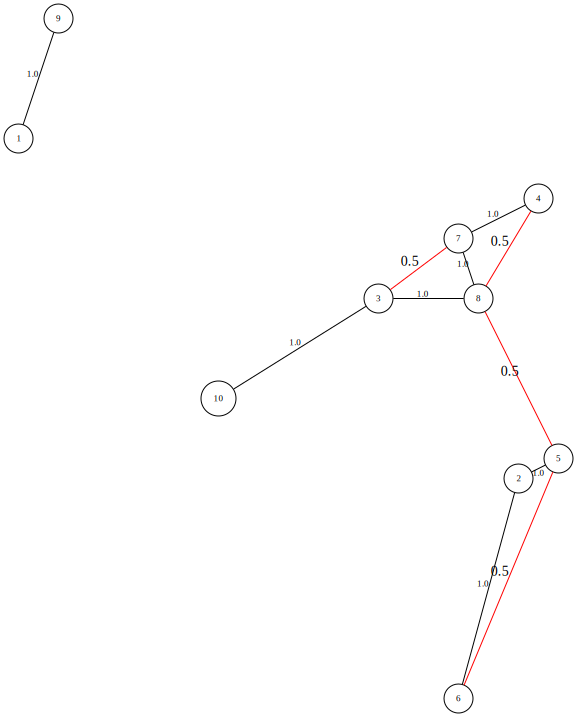

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 39 columns
Presolve time: 0.01s
Presolved: 18 rows, 16 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 81 rows and 46 columns
Presolve time: 0.01s
Presolved: 10 rows, 9 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.00000

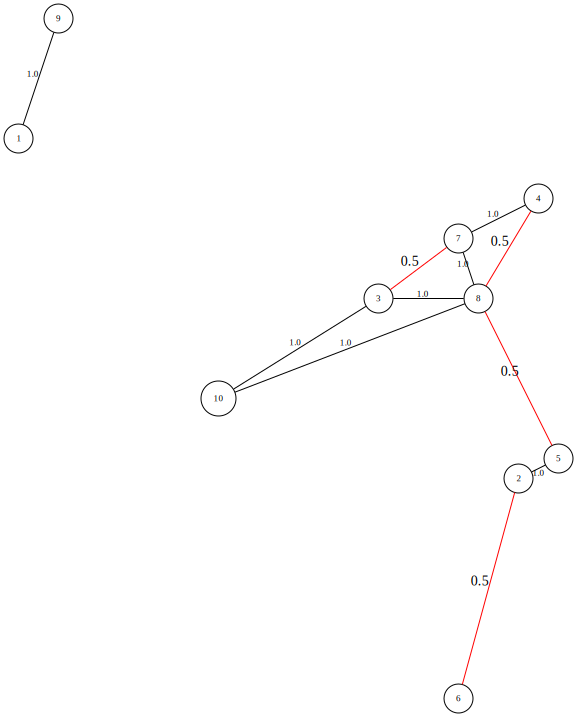

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 77 rows and 43 columns
Presolve time: 0.02s
Presolved: 14 rows, 12 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   4.000000e+00   0.000000e+00      0s
       4   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.03 seconds
Optimal objective -0.000000000e+00
Found violated subtour. S = [1, 3, 4, 7, 8, 10]
Press Enter to continue...

Optimize a model with 7 rows, 45 columns and 132 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0115000e+03   1.000000e+00   0.0000

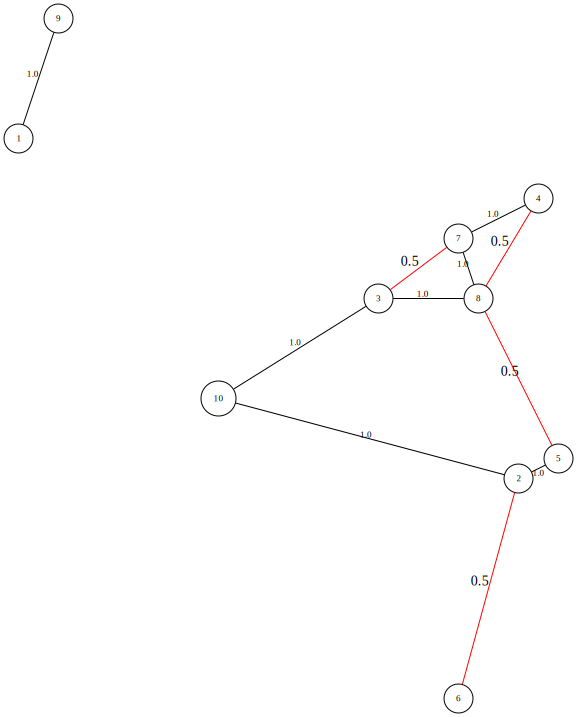

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 39 columns
Presolve time: 0.02s
Presolved: 18 rows, 16 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       6   -5.0000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.04 seconds
Optimal objective -5.000000000e-01
Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8, 10]
Press Enter to continue...

Optimize a model with 8 rows, 45 columns and 160 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1715000e+03   5.000000e-01   

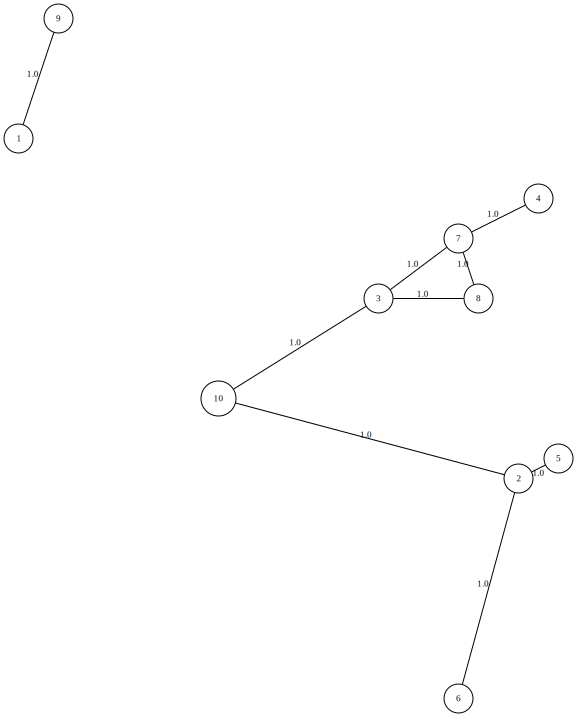

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

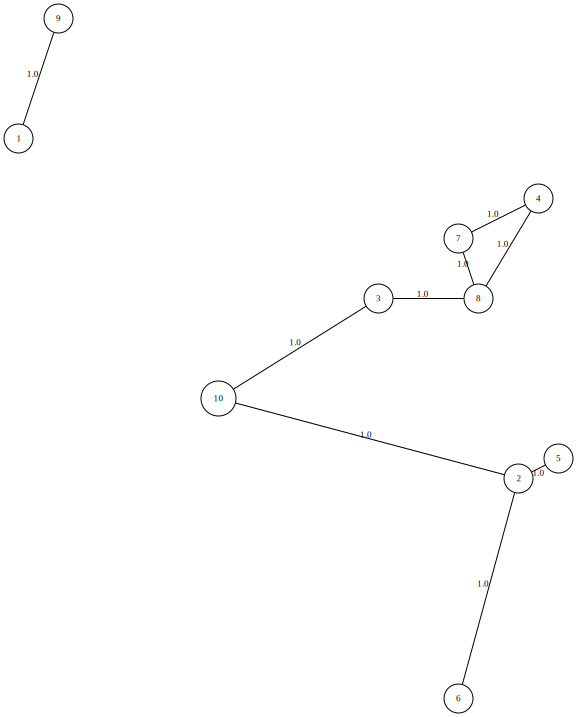

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

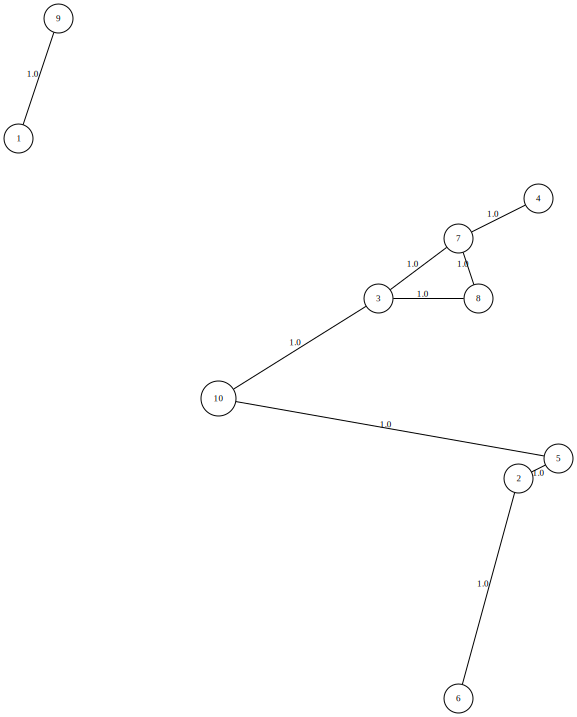

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

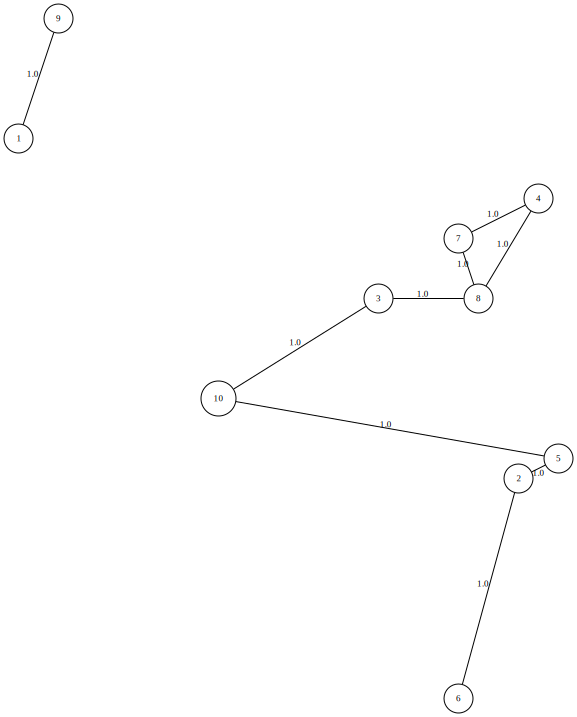

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

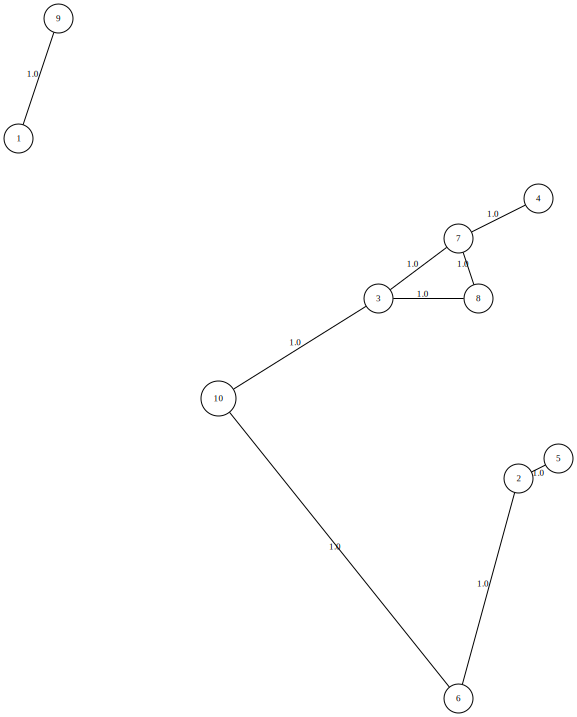

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.02s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

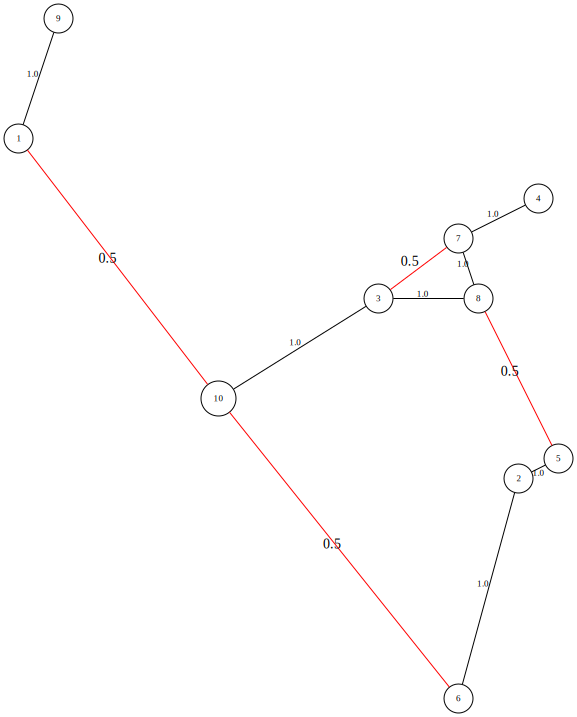

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 75 rows and 40 columns
Presolve time: 0.05s
Presolved: 16 rows, 15 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       5   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.07 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.000000

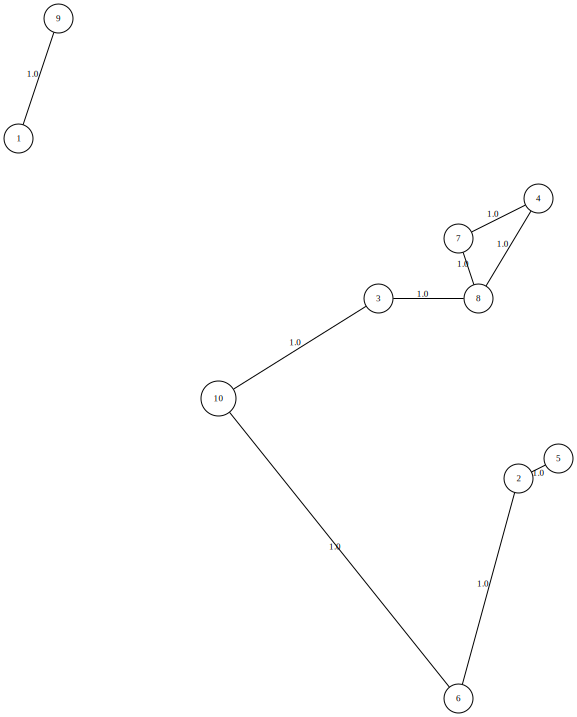

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

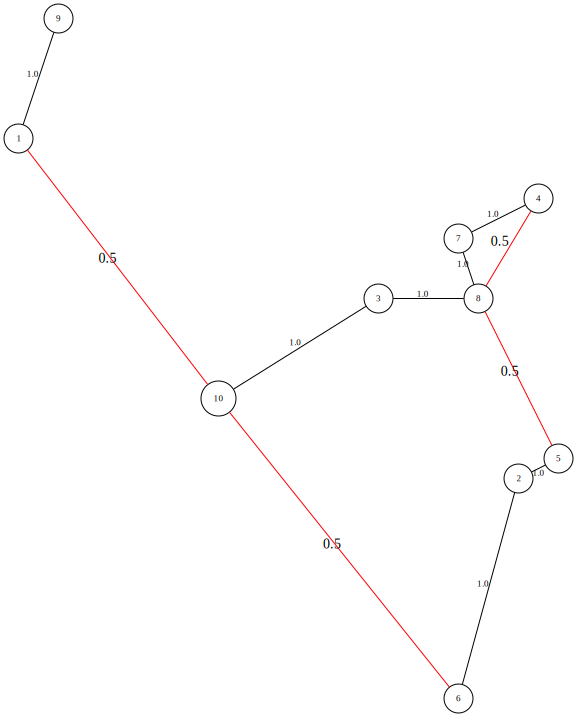

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 38 columns
Presolve time: 0.03s
Presolved: 18 rows, 17 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       5   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.06 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0000000e-0

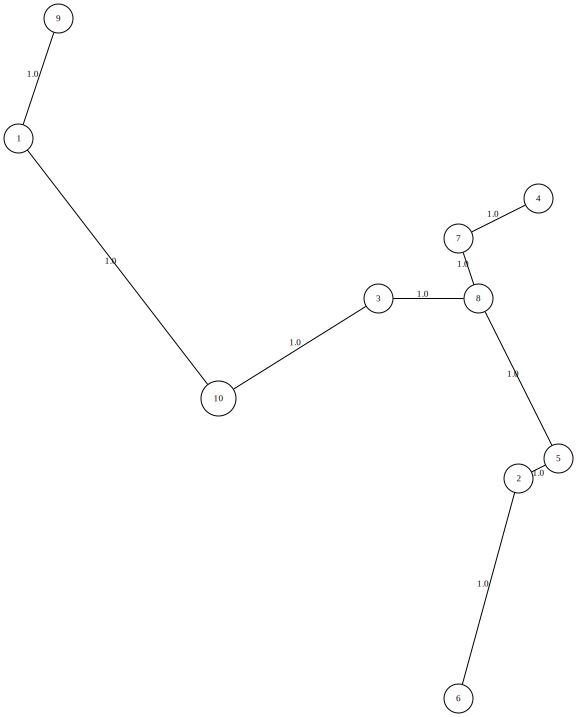

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

In [9]:


cont = True
#ftime = True

#
# Main cutting plane algorithm
#

sec = 1

while cont: 
    mst.optimize()
    print ("Current solution value:", mst.objVal)

    DrawSol(x)
    display(SVG(filename=basename+'_sol.svg'))


    cont = False
    for u in G.nodes():
        status, SEC = SECseparation(x, G, u)
        if status:
            cont = True
            S = G.subgraph(SEC)
            
            print ("Found violated subtour. S =", S.nodes())

            #
            # Constraint is added: 
            # variable key error may arise without  
            # the conditional statement (edge are undirected)
            # 

            mst.addConstr(gb.quicksum(x[i,j] \
                                      if (i,j) in G.edges() else x[j,i] \
                                      for i,j in S.edges()) \
                                      <= S.number_of_nodes() - 1, 'Sec' + str(sec))
            
            sec += 1
            
            mst.write('mstsep.lp')
            input("Press Enter to continue...\n")       
            break

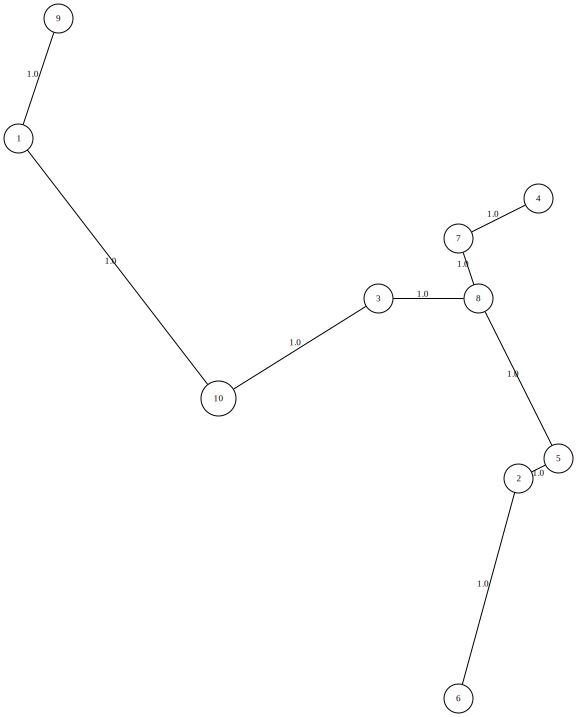

In [10]:
display(SVG(filename=basename+'_sol.svg'))